In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd 

In [18]:
df = pd.read_csv('Ads_Optimisation.csv')
ad_array = df.to_numpy().transpose()


In [19]:
def bandit_strategy_1(n_bandit,k,eps, N, Q, true_opt_arms, opt_arm_pull, q_true, R_pull, bandit_plays,running_avg,running_max):
    for i in range(n_bandit):
        if random.random()<eps: 
            j=np.random.randint(k)
        else : 
            j=np.argmax(Q[i])

        if j==true_opt_arms[i] : # To calculate % optimal action
            opt_arm_pull['opt_arm_pull'] = opt_arm_pull['opt_arm_pull'] + 1

        reward=np.random.normal(q_true[i][j],1)
        R_pull.append(reward)
        N[i][j]=N[i][j]+1
        Q[i][j]=Q[i][j]+(reward-Q[i][j])/N[i][j]

        bandit_plays[j] += 1
        running_avg[j] = (reward - running_avg[j]) / bandit_plays[j]
        running_max[j] += reward

def bandit_strategy_2(n_bandit,k,eps, N, Q, true_opt_arms, opt_arm_pull, q_true, R_pull, bandit_plays,running_avg,running_max):
    for i in range(n_bandit):
        if random.random()<eps: 
            j=np.random.randint(k)
        else : 
            j=np.argmax(Q[i])

        reward=ad_array[j][i]
        R_pull.append(reward)
        N[i][j]=N[i][j]+1
        Q[i][j]=Q[i][j]+(reward-Q[i][j])/N[i][j]

        bandit_plays[j] += 1
        running_avg[j] = (reward - running_avg[j]) / bandit_plays[j]
        running_max[j] += reward

In [20]:
def run_experiment(eps, n_pulls, n_bandit, strat):
    print(f'running for eps {eps}')
    
    k=10 # number of arms in each bandit problem

    q_true=np.random.normal(0,1,(n_bandit,k)) # generating {n_bandit} bandit sets of {k} bandits
    true_opt_arms=np.argmax(q_true,1) # the index of max value of each set to determine optimal bandit percentage

    Q=np.zeros((n_bandit,k)) # reward estimated
    N=np.ones((n_bandit,k)) # number of times each arm was pulled # each arm is pulled atleast once

    R_eps = []
    R_eps_opt = []
    
    m_running_avg = np.zeros(k) # keep track of running averages for each arm
    m_running_max = np.zeros(k) # max reward recorded for each arm


    for pull in range(n_pulls) :  
        R_pull=[] # all rewards in this pull/time-step
        opt_arm_pull = {'opt_arm_pull':0}  # number of times the best arm out of the 10 was selected
        bandit_plays = np.zeros(k) # number of times each bandit was played
        running_avg = np.zeros(k) # keep track of running averages for each arm
        running_max = np.zeros(k) # max reward recorded for each arm
        
        # bandit strategy callback
        strat(n_bandit,k,eps, N, Q, true_opt_arms, opt_arm_pull, q_true, R_pull, bandit_plays,running_avg,running_max)
            
        for i in range(10):
            if m_running_max[i] < running_max[i]:
                m_running_max[i] = running_max[i]
            if m_running_avg[i] < running_avg[i]:
                m_running_avg[i] = running_avg[i]
        
        
        avg_R_pull=np.mean(R_pull)
        R_eps.append(avg_R_pull)
        R_eps_opt.append(float(opt_arm_pull['opt_arm_pull'])*100/2000)
        
    max_index = np.argmax(m_running_max)
    avg_index = np.argmax(m_running_avg)
    arm_data = {
        'eps':eps,
        'pulls': n_pulls,
        'max_total': {'max': round(m_running_max[max_index], 2), 'arm': max_index+1},
        'max_avg': {'max': round(m_running_avg[avg_index], 2), 'arm': avg_index+1}
    }
        
    return R_eps,R_eps_opt, arm_data

In [21]:

def run_experiments_for_epsilons(steps, strat):
    print(f'running experiments for {steps}')
    g_a, g_o, g_data = run_experiment(0.0, steps, 2000, strat)
    e1_a, e1_o, e1_data = run_experiment(0.1, steps, 2000, strat)
    e01_a, e01_o, e01_data = run_experiment(0.01, steps, 2000, strat)
    
    return {
        'greedy': {
            'rewards': g_a,
            'optimize':g_o,
            'arm_data':g_data
        },
        'e1': {
            'rewards': e1_a,
            'optimize':e1_o,
            'arm_data':e1_data
        },
        'e01': {
            'rewards': e01_a,
            'optimize':e01_o,
            'arm_data':e01_data
        }
    }

In [22]:
def print_bandit_data(data):
    eps = data["eps"]
    m_t = data['max_total']['max']
    m_t_arm = data['max_total']['arm']
    m_a = data['max_avg']['max']
    m_a_arm = data['max_avg']['arm']
    print(f'For eps  {eps}')
    print(f'Max Total: with {m_t} from arm {m_t_arm}')
    print(f'Max Avg: with {m_a} from arm {m_a_arm}')
    
def print_data_group(d_array):
    steps = d_array[0]['pulls']
    print(f'For {steps} steps')
    for d in d_array:
        print_bandit_data(d)
    print("\n")

def createGraphs(greedy, ep1, ep01, start, ranges, title):
    fig, a = plt.subplots(figsize=(10,10))
    fig.suptitle(f"10 arm bandit {ranges[0]} steps")

    r = ranges[0]
    a.plot(greedy[start:r], label="greedy")
    a.plot(ep1[start:r], label="epsilon=0.1")
    a.plot(ep01[start:r], label="epsilon=0.01")
    a.set_title(f"{title} " + str(r) + " tasks")
    fig.legend(
        labels=["greedy", "epsilon=0.1", "epsilon=0.01"],
        loc="center right",
        borderaxespad=0.1)
    plt.show()

In [24]:
data_1000 = run_experiments_for_epsilons(1000, bandit_strategy_1)
print('done')

running experiments for 1000
running for eps 0.0
running for eps 0.1
running for eps 0.01
done


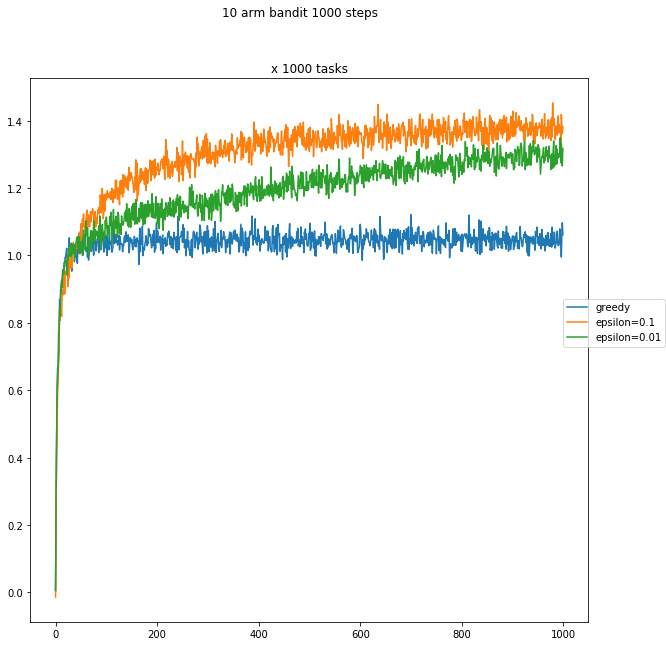

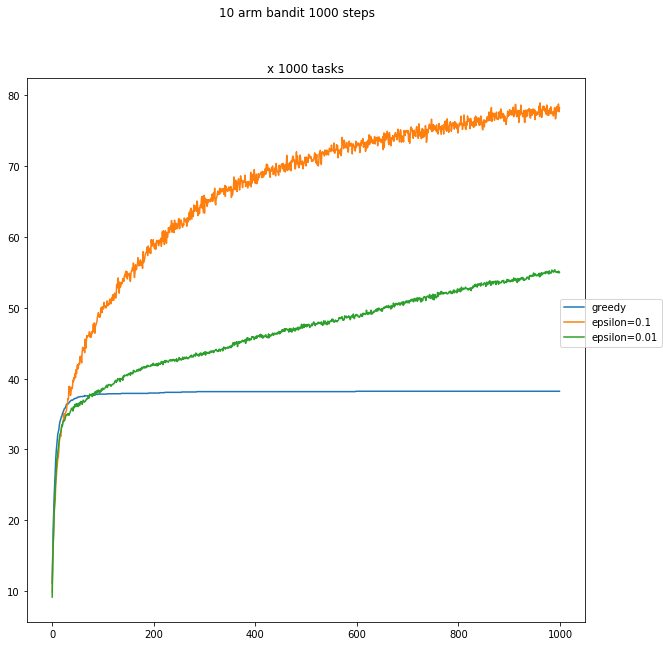

For 1000 steps
For eps  0.0
Max Total: with 704.04 from arm 1
Max Avg: with 0.48 from arm 10
For eps  0.1
Max Total: with 568.29 from arm 1
Max Avg: with 0.12 from arm 4
For eps  0.01
Max Total: with 669.72 from arm 1
Max Avg: with 1.59 from arm 9




In [25]:
# print_bandit_data(e1_data)
createGraphs(
    data_1000['greedy']['rewards'],
    data_1000['e1']['rewards'],
    data_1000['e01']['rewards'],
    0,
    [len(data_1000['greedy']['rewards'])],
    'x')
createGraphs(
    data_1000['greedy']['optimize'],
    data_1000['e1']['optimize'],
    data_1000['e01']['optimize'],
    0,
    [len(data_1000['greedy']['optimize'])],
    'x')

g_data = data_1000['greedy']['arm_data']
e1_data = data_1000['e1']['arm_data']
e01_data = data_1000['e01']['arm_data']
print_data_group([g_data, e1_data, e01_data])

In [16]:
data_10000_ads = run_experiments_for_epsilons(10000, bandit_strategy_2)
print('done')

running experiments for 10000
running for eps 0.0


KeyboardInterrupt: 

In [ ]:
createGraphs(
    data_10000_ads['greedy']['rewards'],
    data_10000_ads['e1']['rewards'],
    data_10000_ads['e01']['rewards'],
    0,
    [1000],
    'x')